# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  At core, we will be constructing a model to classify _candidate_ CDR mentions as either true or false.

## Part I: Preprocessing

In this notebook, we'll preprocess several documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data--which we refer to as _contexts_--as well as extracting standard linguistic features from each context.

In this example, we will extract two types of contexts, represented as `Context` subclasses: `Document` and constituent `Sentence` objects.  In particular, we'll do this using [CoreNLP](http://stanfordnlp.github.io/CoreNLP/), which will also extract a number of standard linguistic features which will be used downstream.

All of this preprocessed input data will be saved to a database.  In Snorkel, if no database is specified, then a SQLite database is created by default- so no setup is needed here!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Corpus

First, we will load and pre-process the corpus, storing it for convenience in a `Corpus` object

### Configuring a document parser

We'll start by defining a `DocParser` class to read in Pubmed abstracts from [Pubtator]([Pubtator](http://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/PubTator/index.cgi)), where they are stored along with "gold" (i.e. hand-annotated by experts) *chemical* and *disease mention* annotations. We'll use the `XMLDocParser` class, which allows us to use [XPath queries](https://en.wikipedia.org/wiki/XPath) to specify the relevant sections of the XML format.

_Note that we are newline-concatenating text from the title and abstract together for simplicity, but if we wanted to, we could easily extend the `DocParser` classes to preserve information about document structure._

In [2]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/CDR_DevelopmentSet.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

### Selecting a sentence parser

Next, we'll use an NLP preprocessing tool to split the `Document` objects into sentences, tokens, and provide annotations--part-of-speech tags, dependency parse structure, lemmatized word forms, etc.--for these sentences.  Here we use the default `SentenceParser` class.

In [3]:
from snorkel.parser import SentenceParser

sent_parser = SentenceParser()

### Pre-processing & loading the corpus

Finally, we'll put this all together using a `CorpusParser` object, which will execute the parsers and store the results as a `Corpus`:

Number of documents: 500
CPU times: user 7.27 s, sys: 238 ms, total: 7.51 s
Wall time: 32.6 s


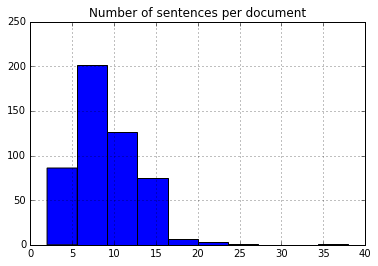

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, sent_parser)
%time corpus = cp.parse_corpus(name='CDR_corpus', session=session)

Note that the printed stats are a property of the `Corpus` object, and can be printed again via the `corpus.stats()` method!

In [5]:
doc = corpus.documents[0]
doc

Document 11900788

In [6]:
sent = doc.sentences[0]
print sent
print sent.words
print sent.poses

Sentence(Document 11900788, 0, u'Nicotine potentiation of morphine-induced catalepsy in mice.')
[u'Nicotine', u'potentiation', u'of', u'morphine-induced', u'catalepsy', u'in', u'mice', u'.']
[u'NN', u'NN', u'IN', u'JJ', u'NN', u'IN', u'NNS', u'.']


### Saving the corpus
Finally, we persist the parsed corpus in Snorkel's database backend:

In [7]:
session.add(corpus)
session.commit()